# 🧪 Практическая работа: Обобщающая способность модели (Food-101 mini)

В этой работе мы разберём, как модель учится обобщать на новых данных,  
и шаг за шагом проведём серию экспериментов на мини-версии датасета **Food-101**.

---

## 🔹 Данные
- Используем датасет **Food-101** (15 классов, уменьшенная выборка).

---

## 🔹 Модель
- Берём **предобученную ResNet-18** из `torchvision`. 

---

## 🔹 Эксперименты
1. **Бейзлайн** — без аугментаций.  
2. **Слабые аугментации** — crop, flip, цветовые искажения.  
3. **Сильные аугментации + регуляризация** — RandAugment, MixUp, Dropout, Label Smoothing.  
4. Сравниваем результаты всех моделей по метрикам и визуализациям.  

---

In [4]:
# ============================================================
# Подготовка окружения: импорты, устройство, конфиг.
# Этот блок ничего не скачивает и не обучает — только настраивает.
# ============================================================
# --- стандартные библиотеки ---
import os, math, random, time
from dataclasses import dataclass
from typing import List, Tuple, Dict
import pandas as pd # для таблиц
import matplotlib.pyplot as plt  # для графиков
import numpy as np

# --- PyTorch ядро ---
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

# Hugging Face Datasets: для загрузки готовых датасетов (изображения, тексты и др.)
from datasets import load_dataset

# TorchVision: стандартные преобразования изображений (resize, crop, normalize и т.д.)
import torchvision.transforms as T
from torchvision.transforms import InterpolationMode

# -----------------------------
# Функция для воспроизводимости
# -----------------------------
# ========== ВОСПРОИЗВОДИМОСТЬ ==========
def set_seed(seed: int = 42) -> None:
    """Фиксирует ГСЧ для повторяемых результатов (Python/NumPy/PyTorch)."""
    os.environ["PYTHONHASHSEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)


set_seed(42)

# -----------------------------
# Определение устройства (CPU/GPU)
# -----------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

if torch.cuda.is_available():
    # Детерминизм на CUDA (чуть медленнее, но стабильнее)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # При необходимости:
    # torch.use_deterministic_algorithms(True)  




Device: cuda


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:104: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00008.parquet:   0%|          | 0.00/490M [00:00<?, ?B/s]

data/train-00001-of-00008.parquet:   0%|          | 0.00/464M [00:00<?, ?B/s]

data/train-00002-of-00008.parquet:   0%|          | 0.00/472M [00:00<?, ?B/s]

data/train-00003-of-00008.parquet:   0%|          | 0.00/464M [00:00<?, ?B/s]

data/train-00004-of-00008.parquet:   0%|          | 0.00/475M [00:00<?, ?B/s]

data/train-00005-of-00008.parquet:   0%|          | 0.00/470M [00:00<?, ?B/s]

data/train-00006-of-00008.parquet:   0%|          | 0.00/478M [00:00<?, ?B/s]

data/train-00007-of-00008.parquet:   0%|          | 0.00/486M [00:00<?, ?B/s]

data/validation-00000-of-00003.parquet:   0%|          | 0.00/423M [00:00<?, ?B/s]

data/validation-00001-of-00003.parquet:   0%|          | 0.00/413M [00:00<?, ?B/s]

data/validation-00002-of-00003.parquet:   0%|          | 0.00/426M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/75750 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/25250 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 75750
    })
    validation: Dataset({
        features: ['image', 'label'],
        num_rows: 25250
    })
})
Классов: 101
Первые 10 классов: ['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare', 'beet_salad', 'beignets', 'bibimbap', 'bread_pudding', 'breakfast_burrito']
Train size: 75,750 | Test size (официальный): 25,250


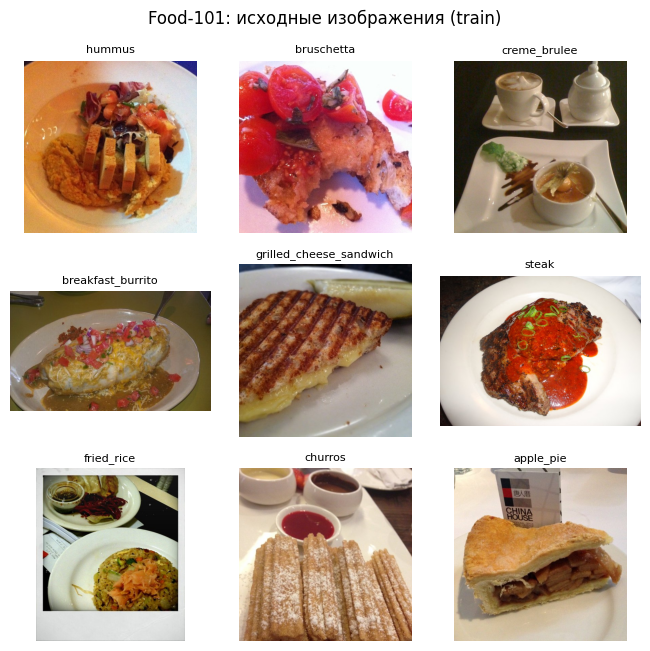

In [5]:
# ===== загрузка Food-101 + check =====
from collections import Counter
from datasets import DatasetDict

DATA_CACHE_DIR = "./data_cache"  # можно поменять на свой путь
ds = load_dataset("food101", cache_dir=DATA_CACHE_DIR)
print(ds)  # какие сплиты и сколько объектов

# В HF: 'validation' = официальный тест Food-101
train_hf = ds["train"]
test_hf  = ds["validation"]

# Список классов и их число
class_names = train_hf.features["label"].names
num_classes = len(class_names)
print(f"Классов: {num_classes}")
print("Первые 10 классов:", class_names[:10])

# Быстрые суммарные размеры (без тяжелых проходов)
print(f"Train size: {len(train_hf):,} | Test size (официальный): {len(test_hf):,}")

# --- универсальная функция для вывода изображений ---
def show_images(split, idxs=None, rows=3, cols=3, seed=42, title="Примеры изображений"):
    set_seed(seed)
    if idxs is None:
        idxs = random.sample(range(len(split)), k=min(rows * cols, len(split)))
    fig, axs = plt.subplots(rows, cols, figsize=(cols * 2.2, rows * 2.2))
    fig.suptitle(title, y=0.98, fontsize=12)
    for ax, i in zip(axs.ravel(), idxs):
        ex = split[int(i)]
        img, label = ex["image"], class_names[int(ex["label"])]
        ax.imshow(img)
        ax.set_title(label, fontsize=8)
        ax.axis("off")
    for ax in axs.ravel()[len(idxs):]:
        ax.axis("off")
    plt.tight_layout()
    plt.show()

# фиксируем 9 случайных индексов, чтобы потом использовать те же
show_images(train_hf, title="Food-101: исходные изображения (train)")

Выбрали 15 классов:
 ['baby_back_ribs', 'breakfast_burrito', 'bruschetta', 'ceviche', 'deviled_eggs', 'dumplings', 'french_toast', 'fried_rice', 'hot_dog', 'macarons', 'nachos', 'panna_cotta', 'poutine', 'prime_rib', 'waffles']
TRAIN (MINI-15) (N=9000)


,class_id,class,count
0,1,baby_back_ribs,600
1,9,breakfast_burrito,600
2,10,bruschetta,600
3,15,ceviche,600
4,30,deviled_eggs,600
5,32,dumplings,600
6,42,french_toast,600
7,44,fried_rice,600
8,55,hot_dog,600
9,63,macarons,600


VAL   (MINI-15) (N=2250)


,class_id,class,count
0,1,baby_back_ribs,150
1,9,breakfast_burrito,150
2,10,bruschetta,150
3,15,ceviche,150
4,30,deviled_eggs,150
5,32,dumplings,150
6,42,french_toast,150
7,44,fried_rice,150
8,55,hot_dog,150
9,63,macarons,150


TEST  (MINI-15) (N=3750)


,class_id,class,count
0,1,baby_back_ribs,250
1,9,breakfast_burrito,250
2,10,bruschetta,250
3,15,ceviche,250
4,30,deviled_eggs,250
5,32,dumplings,250
6,42,french_toast,250
7,44,fried_rice,250
8,55,hot_dog,250
9,63,macarons,250


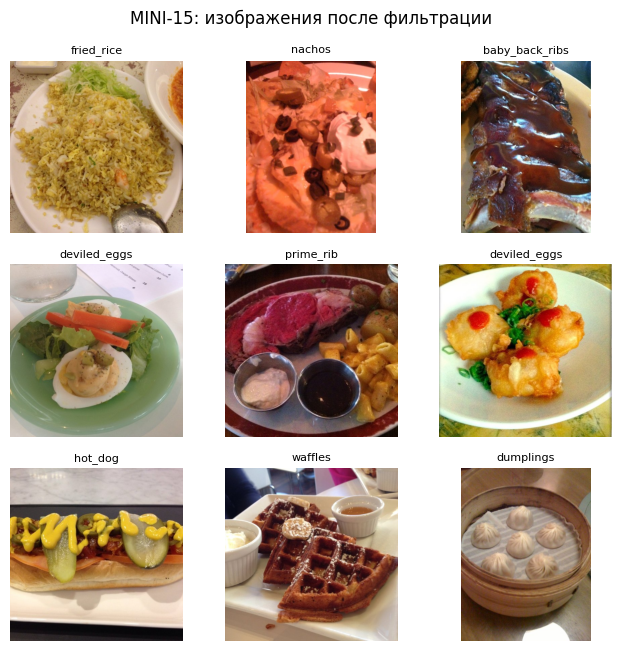

In [6]:
# =============== MINI-15 (train=600, val=150, test=250 на класс) ===============
set_seed(42)  # воспроизводимость выборки

from collections import defaultdict, Counter
from datasets import DatasetDict

K_CLASSES = 15
TRAIN_PER_CLASS = 600
VAL_PER_CLASS   = 150
TEST_PER_CLASS  = 250

# 1) выбираем K классов
all_cls_ids = np.arange(len(class_names))
random.shuffle(all_cls_ids)
chosen_cls = np.sort(all_cls_ids[:K_CLASSES])
chosen_names = [class_names[i] for i in chosen_cls]
print(f"Выбрали {K_CLASSES} классов:\n", chosen_names)

# 2) собираем индексы по классам
by_lbl_train = defaultdict(list)
for i, y in enumerate(train_hf["label"]):
    if y in chosen_cls:
        by_lbl_train[int(y)].append(i)

by_lbl_test = defaultdict(list)
for i, y in enumerate(test_hf["label"]):
    if y in chosen_cls:
        by_lbl_test[int(y)].append(i)

# 3) формируем train/val/test
train_idx_total, val_idx_total, test_idx_total = [], [], []
for c in chosen_cls:
    tr_ids = by_lbl_train[int(c)]
    random.shuffle(tr_ids)
    need_val   = min(VAL_PER_CLASS, len(tr_ids))
    need_train = min(TRAIN_PER_CLASS, max(0, len(tr_ids) - need_val))

    val_idx_c   = tr_ids[:need_val]
    train_idx_c = tr_ids[need_val:need_val + need_train]

    te_ids = by_lbl_test[int(c)]
    random.shuffle(te_ids)
    test_idx_c = te_ids[:min(TEST_PER_CLASS, len(te_ids))]

    val_idx_total.extend(val_idx_c)
    train_idx_total.extend(train_idx_c)
    test_idx_total.extend(test_idx_c)

# 4) собираем HF-сплиты
train_small = train_hf.select(train_idx_total)
val_small   = train_hf.select(val_idx_total)
test_small  = test_hf.select(test_idx_total)

food101_small = DatasetDict({
    "train": train_small,
    "val":   val_small,
    "test":  test_small
})

# 5) быстрая сводка
def balance_table(split, title):
    cnt = Counter(split["label"])
    df = pd.DataFrame({
        "class_id": chosen_cls,
        "class": [class_names[i] for i in chosen_cls],
        "count": [cnt.get(int(c), 0) for c in chosen_cls],
    }).sort_values("class").reset_index(drop=True)
    print(f"{title} (N={len(split)})"); display(df)
    return df

bt_train = balance_table(food101_small["train"], "TRAIN (MINI-15)")
bt_val   = balance_table(food101_small["val"],   "VAL   (MINI-15)")
bt_test  = balance_table(food101_small["test"],  "TEST  (MINI-15)")

# 6) визуальная проверка
SAMPLE_IDX = random.sample(range(len(food101_small["train"])), 9)
show_images(food101_small["train"], SAMPLE_IDX, title="MINI-15: изображения после фильтрации")

In [7]:
# =============== Ремаппер меток под MINI-15 ===============
set_seed(42)

# строим отображение: старый id -> новый [0..NUM_CLASSES-1]
LABEL2NEW = {int(old): i for i, old in enumerate(chosen_cls)}
NEW2LABEL = {v: k for k, v in LABEL2NEW.items()}

NUM_CLASSES = len(chosen_cls)
print("NUM_CLASSES =", NUM_CLASSES)
print("Пример маппинга:", list(LABEL2NEW.items())[:5])

NUM_CLASSES = 15
Пример маппинга: [(1, 0), (9, 1), (10, 2), (15, 3), (30, 4)]


✅ DataLoader'ы готовы: train=9000, val=2250, test=3750, batch=64
Формы батча: torch.Size([64, 3, 224, 224]) torch.Size([64])


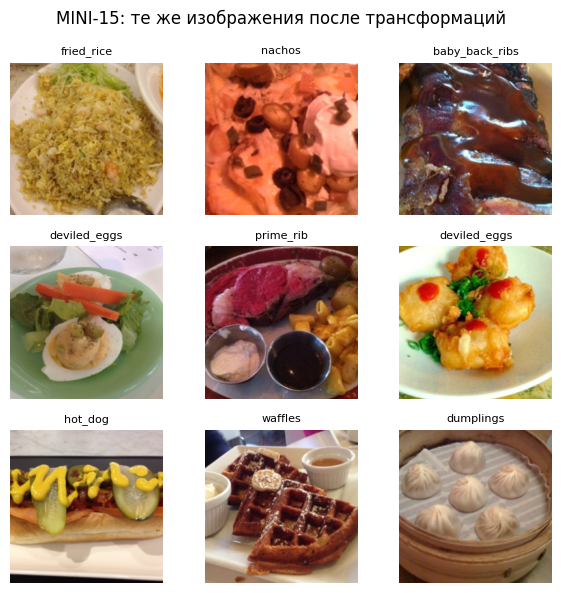

In [8]:
# ===============  трансформации (без аугм) + DataLoader’ы ===============
set_seed(42)

# --- базовые параметры трансформаций ---
IMG_SIZE = 224
MEAN = (0.485, 0.456, 0.406)
STD  = (0.229, 0.224, 0.225)

# --- трансформации (бейзлайн, без аугментаций) ---
baseline_tf = T.Compose([
    T.Resize(256, interpolation=InterpolationMode.BILINEAR),
    T.CenterCrop(IMG_SIZE),
    T.ToTensor(),
    T.Normalize(MEAN, STD),
])

# --- простая обёртка под HF split ---
class HFDataset(torch.utils.data.Dataset):
    def __init__(self, hf_split, transform, label_map):
        self.data = hf_split
        self.tf = transform
        self.label_map = label_map
    def __len__(self): return len(self.data)
    def __getitem__(self, idx):
        ex = self.data[int(idx)]
        x = self.tf(ex["image"])
        y_old = int(ex["label"])
        y = self.label_map[y_old] 
        return x, y

train_ds = HFDataset(food101_small["train"], baseline_tf, LABEL2NEW)
val_ds   = HFDataset(food101_small["val"],   baseline_tf, LABEL2NEW)
test_ds  = HFDataset(food101_small["test"],  baseline_tf, LABEL2NEW)

# --- DataLoader'ы ---
BATCH_SIZE = 64
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  num_workers=0)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

print(f"✅ DataLoader'ы готовы: train={len(train_ds)}, val={len(val_ds)}, test={len(test_ds)}, batch={BATCH_SIZE}")

# --- проверка одного батча ---
xb, yb = next(iter(train_loader))
print('Формы батча:', xb.shape, yb.shape)

# --- визуализация именно тех же картинок, что и в Блоке 2 ---
mean = torch.tensor(MEAN)[:, None, None]
std  = torch.tensor(STD)[:, None, None]
fig, axs = plt.subplots(3, 3, figsize=(6,6))
fig.suptitle("MINI-15: те же изображения после трансформаций", y=0.98, fontsize=12)

for ax, idx in zip(axs.ravel(), SAMPLE_IDX):
    ex = food101_small["train"][idx]
    img_after = baseline_tf(ex["image"])
    img_show = (img_after * std + mean).permute(1,2,0).numpy().clip(0,1)
    ax.imshow(img_show)
    ax.set_title(class_names[int(ex["label"])], fontsize=8)
    ax.axis("off")

plt.tight_layout(); plt.show()


### Препроцессинг под ResNet и DataLoader’ы

Дальше в качестве базовой модели мы будем использовать **ResNet-18**, предобученный на датасете **ImageNet**.  
Это классическая архитектура, которая служит «стандартом де-факто» для визуальных экспериментов:  
она лёгкая, стабильная, и хорошо показывает общие принципы обобщения модели.

#### 🔹 Почему важно подать данные в том же формате, что и у ImageNet

Предобученные модели в `torchvision` (ResNet, VGG, EfficientNet и др.) обучались на **ImageNet-1k**,  
и ожидают входные изображения в строго определённом формате:

| Параметр | Значение | Назначение |
|-----------|-----------|------------|
| Размер входа | **224×224 px** | фиксированный вход для свёрточной архитектуры |
| Диапазон пикселей | `[0, 1]` после `ToTensor()` | нормализованный масштаб значений |
| Средние значения каналов | **mean = (0.485, 0.456, 0.406)** | средние значения RGB по всему ImageNet |
| Стандартные отклонения | **std = (0.229, 0.224, 0.225)** | разброс значений RGB по всему ImageNet |

Модель была обучена на данных, предварительно стандартизованных по этим статистикам,  
поэтому при инференсе и дообучении нужно использовать **точно такие же** значения.  
Если этого не сделать — распределение входных признаков изменится, и веса, рассчитанные на центрированные данные,  
начнут давать смещения: метрики резко ухудшаются.

#### 🔹 Наш препроцессинг под ResNet

Мы используем базовый пайплайн:
Resize(256) → CenterCrop(224) → ToTensor() → Normalize(mean, std)

- **Resize + CenterCrop** — подгоняет размер и обрезает центр кадра,  
  как делалось при обучении ResNet на ImageNet.  
- **ToTensor** — переводит из PIL-изображения в формат PyTorch `[C, H, W]`, диапазон `[0, 1]`.  
- **Normalize** — приводит данные к тем же статистикам (mean/std), что использовались при предобучении.
  

In [9]:
# =============== Инициализация модели ResNet-18 (бейзлайн) ===============
set_seed(42)

from torchvision import models

NUM_CLASSES = 15  # наша mini-версия Food-101
USE_PRETRAINED = True

# 1) Загружаем предобученный ResNet-18
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1 if USE_PRETRAINED else None)

# 2) Замораживаем backbone (все сверточные блоки)
for name, param in model.named_parameters():
    param.requires_grad = False

# 3) Заменяем "голову" (fc) под нашу задачу
in_features = model.fc.in_features
model.fc = nn.Linear(in_features, NUM_CLASSES)

# 4) Переносим на GPU
model = model.to(device)

# 5) Короткий отчёт
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"✅ ResNet-18 загружен: всего параметров = {total_params/1e6:.2f}M, "
      f"обучаемых = {trainable_params/1e6:.2f}M")

# 6) Проверяем, что голова действительно новая
print(model.fc)

# 7) Тестовый прогон одного батча
xb, yb = next(iter(train_loader))
xb = xb.to(device)
with torch.no_grad():
    out = model(xb)
print("Выход модели:", out.shape)  # [batch, NUM_CLASSES]


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 128MB/s]


✅ ResNet-18 загружен: всего параметров = 11.18M, обучаемых = 0.01M
Linear(in_features=512, out_features=15, bias=True)
Выход модели: torch.Size([64, 15])


### Заморозка слоев и что такое Transfer Learning

Мы используем **ResNet-18**, уже обученный на большом датасете **ImageNet**  
(1,2 млн изображений, 1000 классов).  
Эта модель уже умеет находить общие визуальные закономерности:  
границы, текстуры, формы и простые объекты.  

#### 🔹 Идея Transfer Learning
Вместо того чтобы обучать сеть с нуля, мы **переносим знания** из одной задачи в другую:
1. Берём предобученную модель — это наш «донор» признаков.  
2. **Замораживаем скелет модели(backbone)** (все свёрточные слои):  
   не обновляем их веса, чтобы не потерять универсальные паттерны.  
3. **Заменяем только «голову» (fc-слой)** под нужное число классов — в нашем случае 15.  
4. Обучаем только эту голову, чтобы адаптировать признаки под новую задачу.

#### 🔹 Зачем это нужно
- Экономим вычислительные ресурсы — обучаем лишь ~0.01 M параметров вместо 11 M.  
- Получаем высокое качество даже при маленьком датасете.  
- Backbone уже умеет «обобщать» — переносит визуальные закономерности с ImageNet на наш Food-101.  

#### 🔹 Почему обучаем именно FC-слой
Последний слой (**Fully Connected**, или просто `fc`)  
— это классификатор, который принимает вектор признаков из backbone  
(например, 512 признаков у ResNet-18)  
и преобразует его в логиты размерности `[количество_классов]`.  

Обучаем именно этот слой, потому что:
- он отвечает за **привязку универсальных признаков к новым классам** (нашим 15 категориям еды);
- его обучение не разрушает знания, уже заложенные в backbone;

In [11]:
from tqdm.auto import tqdm
import torch
import os

set_seed(42)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.fc.parameters(), lr=1e-3)

EPOCHS = 10
history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}

# ---- настройки чекпоинта ----
best_val_loss = float("inf")
patience = 3
no_improve_epochs = 0
checkpoint_path = "best_model.pt"  # сохранится в корень (текущая рабочая директория)

def accuracy_from_logits(logits, targets):
    preds = logits.argmax(1)
    return (preds == targets).float().mean().item()

for epoch in range(1, EPOCHS + 1):
    # ---- TRAIN ----
    model.train()
    train_loss = train_acc = 0.0
    n_train = 0

    for xb, yb in tqdm(train_loader, desc=f"Epoch {epoch}/{EPOCHS} [train]", leave=False):
        xb = xb.to(device, non_blocking=True)
        yb = yb.to(device, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)
        logits = model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()

        bs = yb.size(0)
        n_train += bs
        train_loss += loss.item() * bs
        train_acc  += accuracy_from_logits(logits, yb) * bs

    train_loss /= n_train
    train_acc  /= n_train

    # ---- VAL ----
    model.eval()
    val_loss = val_acc = 0.0
    n_val = 0
    for xb, yb in tqdm(val_loader, desc=f"Epoch {epoch}/{EPOCHS} [val]", leave=False):
        xb = xb.to(device, non_blocking=True)
        yb = yb.to(device, non_blocking=True)
        with torch.no_grad():
            logits = model(xb)
            loss = criterion(logits, yb)
        bs = yb.size(0)
        n_val += bs
        val_loss += loss.item() * bs
        val_acc  += accuracy_from_logits(logits, yb) * bs

    val_loss /= n_val
    val_acc  /= n_val

    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_loss)
    history["train_acc"].append(train_acc)
    history["val_acc"].append(val_acc)

    print(f"Epoch {epoch:02d}/{EPOCHS} | "
          f"train_loss={train_loss:.4f} val_loss={val_loss:.4f} | "
          f"train_acc={train_acc*100:.1f}% val_acc={val_acc*100:.1f}%")

    # ---- сохранение лучшего чекпоинта ----
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        no_improve_epochs = 0
        torch.save({
            "epoch": epoch,
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "val_loss": val_loss,
        }, checkpoint_path)
        print(f"💾 Новый лучший чекпоинт сохранён (epoch {epoch})")
    else:
        no_improve_epochs += 1
        print(f"⚠️ Нет улучшения {no_improve_epochs} эпох подряд")

    # ---- early stopping ----
    if no_improve_epochs >= patience:
        print("⛔ Early stopping — улучшений нет, обучение прервано.")
        break

print("✅ Обучение завершено.")
print(f"Лучший чекпоинт сохранён в: {os.path.abspath(checkpoint_path)}")


Epoch 1/10 [train]:   0%|          | 0/141 [00:00<?, ?it/s]

Epoch 1/10 [val]:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 01/10 | train_loss=0.6734 val_loss=0.8077 | train_acc=79.3% val_acc=74.0%
💾 Новый лучший чекпоинт сохранён (epoch 1)


Epoch 2/10 [train]:   0%|          | 0/141 [00:00<?, ?it/s]

Epoch 2/10 [val]:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 02/10 | train_loss=0.6560 val_loss=0.8089 | train_acc=80.0% val_acc=74.1%
⚠️ Нет улучшения 1 эпох подряд


Epoch 3/10 [train]:   0%|          | 0/141 [00:00<?, ?it/s]

Epoch 3/10 [val]:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 03/10 | train_loss=0.6427 val_loss=0.7914 | train_acc=80.1% val_acc=75.4%
💾 Новый лучший чекпоинт сохранён (epoch 3)


Epoch 4/10 [train]:   0%|          | 0/141 [00:00<?, ?it/s]

Epoch 4/10 [val]:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 04/10 | train_loss=0.6378 val_loss=0.7913 | train_acc=80.2% val_acc=74.7%
💾 Новый лучший чекпоинт сохранён (epoch 4)


Epoch 5/10 [train]:   0%|          | 0/141 [00:00<?, ?it/s]

Epoch 5/10 [val]:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 05/10 | train_loss=0.6285 val_loss=0.7894 | train_acc=80.2% val_acc=74.7%
💾 Новый лучший чекпоинт сохранён (epoch 5)


Epoch 6/10 [train]:   0%|          | 0/141 [00:00<?, ?it/s]

Epoch 6/10 [val]:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 06/10 | train_loss=0.6161 val_loss=0.7914 | train_acc=80.5% val_acc=75.5%
⚠️ Нет улучшения 1 эпох подряд


Epoch 7/10 [train]:   0%|          | 0/141 [00:00<?, ?it/s]

Epoch 7/10 [val]:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 07/10 | train_loss=0.6035 val_loss=0.7941 | train_acc=81.3% val_acc=75.2%
⚠️ Нет улучшения 2 эпох подряд


Epoch 8/10 [train]:   0%|          | 0/141 [00:00<?, ?it/s]

Epoch 8/10 [val]:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 08/10 | train_loss=0.6015 val_loss=0.8105 | train_acc=81.0% val_acc=74.9%
⚠️ Нет улучшения 3 эпох подряд
⛔ Early stopping — улучшений нет, обучение прервано.
✅ Обучение завершено.
Лучший чекпоинт сохранён в: /content/best_model.pt


In [12]:
from sklearn.metrics import accuracy_score, f1_score

set_seed(42)

@torch.no_grad()
def evaluate(model, dataloader):
    """Вычисление accuracy и macro-F1 на заданном split."""
    model.eval()
    all_preds, all_labels = [], []
    for xb, yb in dataloader:
        xb, yb = xb.to(device), yb.to(device)
        preds = model(xb).argmax(1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(yb.cpu().numpy())
    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average="macro")
    return acc, f1

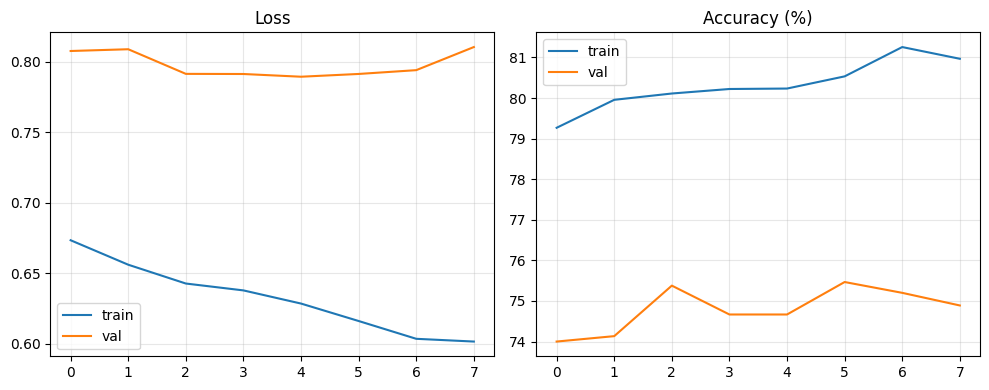

[VAL]  Acc=74.89% | Macro-F1=0.748
[TEST] Acc=78.64% | Macro-F1=0.785


In [14]:
# ---- ГРАФИКИ ----
fig, axs = plt.subplots(1, 2, figsize=(10,4))
axs[0].plot(history["train_loss"], label="train")
axs[0].plot(history["val_loss"],   label="val")
axs[0].set_title("Loss"); axs[0].legend(); axs[0].grid(True, alpha=0.3)

axs[1].plot(np.array(history["train_acc"])*100, label="train")
axs[1].plot(np.array(history["val_acc"])*100,   label="val")
axs[1].set_title("Accuracy (%)"); axs[1].legend(); axs[1].grid(True, alpha=0.3)
plt.tight_layout(); plt.show()

# ---- Итоговые метрики: VAL и TEST (Accuracy, Macro-F1) ----
val_acc, val_f1 = evaluate(model, val_loader)
test_acc, test_f1 = evaluate(model, test_loader)
print(f"[VAL]  Acc={val_acc*100:.2f}% | Macro-F1={val_f1:.3f}")
print(f"[TEST] Acc={test_acc*100:.2f}% | Macro-F1={test_f1:.3f}")

In [15]:
import os, torch

checkpoint_path = "best_model.pt"
assert os.path.exists(checkpoint_path), f"Чекпоинт не найден: {checkpoint_path}"
ckpt = torch.load(checkpoint_path, map_location=device)

# Достаём state_dict из разных вариантов сохранения
if "model_state_dict" in ckpt:
    state = ckpt["model_state_dict"]
elif "state_dict" in ckpt:  # иногда так сохраняют (e.g. Lightning)
    state = ckpt["state_dict"]
else:
    # возможно, сохранён чистый state_dict без обёртки
    state = ckpt

# (необязательно) Проверка метаданных, если сохранял их
if "num_classes" in ckpt:
    assert ckpt["num_classes"] == NUM_CLASSES, \
        f"NUM_CLASSES в ckpt={ckpt['num_classes']} != текущему={NUM_CLASSES}"
if "chosen_cls" in ckpt:
    assert list(ckpt["chosen_cls"]) == list(map(int, chosen_cls)), \
        "Порядок chosen_cls отличается от того, с которым обучалась модель"

# Загружаем веса
model.load_state_dict(state, strict=True)
model = model.to(device).eval()
print(f"✅ Загружен чекпоинт: {checkpoint_path}")


✅ Загружен чекпоинт: best_model.pt


---

## Шаг 1. Подготовка: Замер бейзлайна

В этом блоке мы замеряем метрики **Top-1**, **F1-macro**, **ECE** для базовой модели на тестовом наборе.  
Это наш **личный бейзлайн**, с которым будем сравнивать улучшения.

**Метрики:**
- **Top-1 Accuracy** — доля правильных предсказаний (первая гипотеза)
- **F1-macro** — среднее F1-score по всем классам (без учета дисбаланса)
- **ECE (Expected Calibration Error)** — мера калиброванности модели (разница между уверенностью и точностью)

**Важно:** Используем функции из практики, не пишем новые реализации.

---


In [16]:
# =============== Шаг 1: Замер метрик базовой модели (бейзлайн) ===============
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score
from tqdm.auto import tqdm

set_seed(42)

# Убеждаемся, что модель загружена и в режиме eval
model.eval()

# Функция для сбора предсказаний и вероятностей (для ECE нужны вероятности)
@torch.no_grad()
def collect_predictions_and_probs(model, dataloader):
    """Собирает истинные метки, предсказания и вероятности."""
    y_true, y_pred, y_probs = [], [], []
    for xb, yb in tqdm(dataloader, desc="Сбор предсказаний [test]", leave=False):
        xb = xb.to(device, non_blocking=True)
        yb = yb.to(device, non_blocking=True)
        logits = model(xb)
        probs = torch.softmax(logits, dim=1)
        preds = logits.argmax(1)
        
        y_true.extend(yb.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())
        y_probs.append(probs.cpu().numpy())
    
    y_true = np.array(y_true, dtype=int)
    y_pred = np.array(y_pred, dtype=int)
    y_probs = np.concatenate(y_probs, axis=0)
    
    return y_true, y_pred, y_probs

# Функция для вычисления ECE (из практики - та же реализация)
def expected_calibration_error(y_true, prob, n_bins=15):
    """
    Вычисляет Expected Calibration Error (ECE).
    
    ECE измеряет разницу между уверенностью модели (максимальная вероятность)
    и её фактической точностью в каждом бине уверенности.
    """
    p = prob.max(axis=1)  # максимальная вероятность (уверенность)
    y_pred = prob.argmax(1)  # предсказанный класс
    correct = (y_pred == y_true).astype(int)  # правильность предсказания
    
    bins = np.linspace(0, 1, n_bins + 1)
    ece = 0.0
    
    for i in range(n_bins):
        lo, hi = bins[i], bins[i + 1]
        # Для последнего бина включаем правую границу
        if i < n_bins - 1:
            mask = (p >= lo) & (p < hi)
        else:
            mask = (p >= lo) & (p <= hi)
        
        if mask.sum() == 0:
            continue
        
        # Средняя уверенность в бине
        conf_bin = p[mask].mean()
        # Фактическая точность в бине
        acc_bin = correct[mask].mean()
        # Доля примеров в бине
        weight = mask.mean()
        
        # Вклад бина в ECE
        ece += weight * abs(acc_bin - conf_bin)
    
    return ece

# Собираем предсказания и вероятности на тестовом наборе
print("Сбор предсказаний базовой модели на тестовом наборе...")
y_true_test, y_pred_test, y_probs_test = collect_predictions_and_probs(model, test_loader)

# Вычисляем метрики используя функции из практики
# Top-1 Accuracy (используем accuracy_score из sklearn, как в практике)
top1_acc = accuracy_score(y_true_test, y_pred_test)

# F1-macro (используем f1_score с average="macro", как в практике)
f1_macro = f1_score(y_true_test, y_pred_test, average="macro")

# ECE (используем функцию expected_calibration_error из практики)
ece = expected_calibration_error(y_true_test, y_probs_test)

# Выводим результаты
print("\n" + "="*60)
print("МЕТРИКИ БАЗОВОЙ МОДЕЛИ (БЕЙЗЛАЙН) НА ТЕСТОВОМ НАБОРЕ")
print("="*60)
print(f"Top-1 Accuracy:  {top1_acc*100:.2f}%")
print(f"F1-macro:        {f1_macro:.4f}")
print(f"ECE:             {ece:.4f}")
print("="*60)

# Сохраняем результаты в словарь для дальнейшего сравнения
baseline_metrics = {
    "Top-1": top1_acc,
    "F1-macro": f1_macro,
    "ECE": ece
}

print("\nБейзлайн сохранён для сравнения с улучшенными моделями.")
print(f"Результаты сохранены в словарь 'baseline_metrics'")


Сбор предсказаний базовой модели на тестовом наборе...


Сбор предсказаний [test]:   0%|          | 0/59 [00:00<?, ?it/s]


МЕТРИКИ БАЗОВОЙ МОДЕЛИ (БЕЙЗЛАЙН) НА ТЕСТОВОМ НАБОРЕ
Top-1 Accuracy:  79.28%
F1-macro:        0.7910
ECE:             0.0294

Бейзлайн сохранён для сравнения с улучшенными моделями.
Результаты сохранены в словарь 'baseline_metrics'


---

## Шаг 2. Улучшение генерализации

Реализуем **минимум два метода** улучшения обобщающей способности модели:

### Метод 1: **Label Smoothing** 
Смягчаем метки в loss функции, заменяя жесткие one-hot метки на распределение с небольшой вероятностью для всех классов. Это помогает модели быть менее самоуверенной и лучше обобщаться.

**Интеграция:** Реализован в loss функции через `CrossEntropyLoss` с параметром `label_smoothing=0.1`.

### Метод 2: **RandAugment (сильные аугментации)**
Используем RandAugment - автоматический метод выбора и применения аугментаций, который значительно увеличивает разнообразие обучающих данных и улучшает обобщение.

**Интеграция:** Применяется в трансформациях для обучающего набора данных через `T.RandAugment()`.

### Дополнительные улучшения:
- **Dropout** (p=0.3) в голове модели - снижает переобучение
- **Weight Decay** (1e-4) через AdamW - L2-регуляризация весов

**Важно:** Оценка проводится на том же валидационном сплите и eval-пайплайне, что и baseline (без аугментаций на val/test).

---


In [45]:
# =============== Шаг 2: Улучшенная модель (Dropout + Weight Decay) ===============
from tqdm.auto import tqdm
from torchvision import models
import torch

set_seed(42)

print("="*70)

model_improved = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

for param in model_improved.parameters():
    param.requires_grad = False

in_features = model_improved.fc.in_features
model_improved.fc = nn.Sequential(
    nn.Dropout(p=0.1),
    nn.Linear(in_features, NUM_CLASSES)
)

model_improved = model_improved.to(device)


baseline_tf = T.Compose([
    T.Resize(256, interpolation=InterpolationMode.BILINEAR),
    T.CenterCrop(IMG_SIZE),
    T.ToTensor(),
    T.Normalize(MEAN, STD),
])

train_ds = HFDataset(food101_small["train"], baseline_tf, LABEL2NEW)
val_ds = HFDataset(food101_small["val"], baseline_tf, LABEL2NEW)
test_ds = HFDataset(food101_small["test"], baseline_tf, LABEL2NEW)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

In [ ]:
# =============== ОБУЧЕНИЕ УЛУЧШЕННОЙ МОДЕЛИ ===============
set_seed(42)

print("\n" + "="*70)


criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(
    model_improved.fc.parameters(), 
    lr=0.001,
    weight_decay=1e-4
)

print(f"2. Оптимизатор: AdamW с weight_decay=1e-4")

EPOCHS = 15 
history_improved = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}

best_val_loss = float("inf")
patience = 5
no_improve = 0
checkpoint_path_improved = "best_model_improved_15epochs.pt"

print("-"*70)

for epoch in range(1, EPOCHS + 1):
    # ===== TRAIN =====
    model_improved.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0
    
    pbar = tqdm(train_loader, desc=f"Epoch {epoch}/{EPOCHS} [train]", leave=False)
    for inputs, targets in pbar:
        inputs, targets = inputs.to(device), targets.to(device)
        
        optimizer.zero_grad()
        outputs = model_improved(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        _, predicted = outputs.max(1)
        train_total += targets.size(0)
        train_correct += predicted.eq(targets).sum().item()
        
    train_acc = 100. * train_correct / train_total
    avg_train_loss = train_loss / len(train_loader)
    
    # ===== VALIDATION =====
    model_improved.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model_improved(inputs)
            loss = criterion(outputs, targets)
            
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            val_total += targets.size(0)
            val_correct += predicted.eq(targets).sum().item()
    
    val_acc = 100. * val_correct / val_total
    avg_val_loss = val_loss / len(val_loader)
    
    history_improved["train_loss"].append(avg_train_loss)
    history_improved["val_loss"].append(avg_val_loss)
    history_improved["train_acc"].append(train_acc)
    history_improved["val_acc"].append(val_acc)
    
    print(f'\nEpoch {epoch:02d}/{EPOCHS}:')
    print(f'  Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.2f}%')
    print(f'  Val Loss:   {avg_val_loss:.4f}, Val Acc:   {val_acc:.2f}%')
    
    loss_gap = avg_val_loss - avg_train_loss
    acc_gap = train_acc - val_acc
    print(f'  Разница:    loss={loss_gap:+.4f}, acc={acc_gap:+.2f}%')
    
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        no_improve = 0
        torch.save({
            'epoch': epoch,
            'model_state_dict': model_improved.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_loss': avg_val_loss,
            'val_acc': val_acc,
            'train_acc': train_acc,
            'train_loss': avg_train_loss,
            'num_classes': NUM_CLASSES,
            'chosen_cls': list(map(int, chosen_cls)),
            'label_map': LABEL2NEW,
        }, checkpoint_path_improved)
        print(f'  Сохранена лучшая модель (Val Loss: {avg_val_loss:.4f})')
    else:
        no_improve += 1
        print(f'  Нет улучшения {no_improve}/{patience} эпох')
    
    # Ранняя остановка
    if no_improve >= patience:
        print(f'\nРанняя остановка на эпохе {epoch}')
        break



2. Оптимизатор: AdamW с weight_decay=1e-4
----------------------------------------------------------------------


Epoch 1/15 [train]:   0%|          | 0/141 [00:00<?, ?it/s]


Epoch 01/15:
  Train Loss: 1.7525, Train Acc: 50.00%
  Val Loss:   1.2380, Val Acc:   64.58%
  Разница:    loss=-0.5145, acc=-14.58%
  Сохранена лучшая модель (Val Loss: 1.2380)


Epoch 2/15 [train]:   0%|          | 0/141 [00:00<?, ?it/s]


Epoch 02/15:
  Train Loss: 1.1238, Train Acc: 68.19%
  Val Loss:   1.0114, Val Acc:   70.80%
  Разница:    loss=-0.1125, acc=-2.61%
  Сохранена лучшая модель (Val Loss: 1.0114)


Epoch 3/15 [train]:   0%|          | 0/141 [00:00<?, ?it/s]


Epoch 03/15:
  Train Loss: 0.9674, Train Acc: 71.68%
  Val Loss:   0.9233, Val Acc:   70.80%
  Разница:    loss=-0.0441, acc=+0.88%
  Сохранена лучшая модель (Val Loss: 0.9233)


Epoch 4/15 [train]:   0%|          | 0/141 [00:00<?, ?it/s]


Epoch 04/15:
  Train Loss: 0.9030, Train Acc: 73.06%
  Val Loss:   0.8876, Val Acc:   72.04%
  Разница:    loss=-0.0155, acc=+1.01%
  Сохранена лучшая модель (Val Loss: 0.8876)


Epoch 5/15 [train]:   0%|          | 0/141 [00:00<?, ?it/s]


Epoch 05/15:
  Train Loss: 0.8614, Train Acc: 73.41%
  Val Loss:   0.8590, Val Acc:   72.76%
  Разница:    loss=-0.0024, acc=+0.66%
  Сохранена лучшая модель (Val Loss: 0.8590)


Epoch 6/15 [train]:   0%|          | 0/141 [00:00<?, ?it/s]

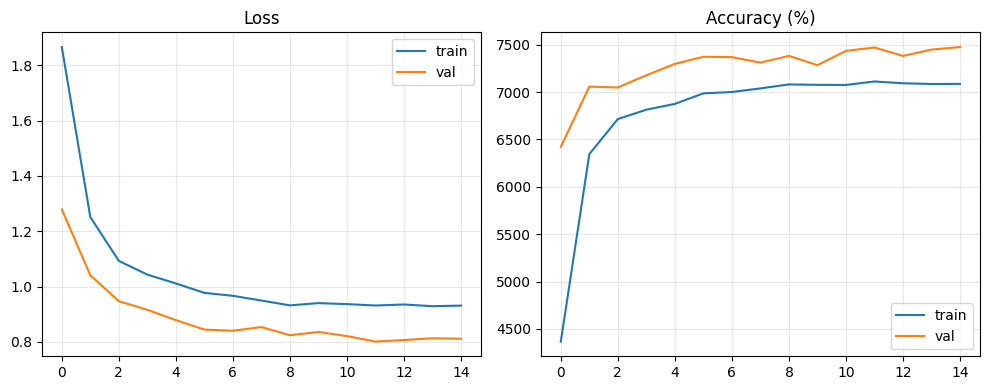

In [35]:
# Визуализация процесса обучения
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
axs[0].plot(history_improved["train_loss"], label="train")
axs[0].plot(history_improved["val_loss"], label="val")
axs[0].set_title("Loss")
axs[0].legend()
axs[0].grid(True, alpha=0.3)

axs[1].plot(np.array(history_improved["train_acc"]) * 100, label="train")
axs[1].plot(np.array(history_improved["val_acc"]) * 100, label="val")
axs[1].set_title("Accuracy (%)")
axs[1].legend()
axs[1].grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


---

## Шаг 3. Оценка и сравнение моделей

Сравниваем Baseline и улучшенную модель по метрикам:
- Top-1 Accuracy
- F1-macro
- ECE (Expected Calibration Error)
- Confusion Matrix
- Reliability Diagram

Анализируем:
- Разница между train и val (признак переобучения)
- Изменение уверенности модели

---


In [42]:
# =============== Шаг 3: Загрузка моделей и сбор предсказаний ===============
import os
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

set_seed(42)

# Загружаем baseline модель
checkpoint_path_baseline = "best_model.pt"
if os.path.exists(checkpoint_path_baseline):
    ckpt_baseline = torch.load(checkpoint_path_baseline, map_location=device)
    model_baseline = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
    for param in model_baseline.parameters():
        param.requires_grad = False
    model_baseline.fc = nn.Linear(model_baseline.fc.in_features, NUM_CLASSES)
    model_baseline.load_state_dict(ckpt_baseline["model_state_dict"])
    model_baseline = model_baseline.to(device).eval()
    print("Baseline модель загружена")
else:
    print("Ошибка: baseline чекпоинт не найден")
    model_baseline = None

# Загружаем улучшенную модель
checkpoint_path_improved = "best_model_improved_15epochs.pt"
if os.path.exists(checkpoint_path_improved):
    ckpt_improved = torch.load(checkpoint_path_improved, map_location=device)
    model_improved_loaded = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
    
    for param in model_improved_loaded.parameters():
        param.requires_grad = False
    
    in_features = model_improved_loaded.fc.in_features
    model_improved_loaded.fc = nn.Sequential(
        nn.Dropout(p=0.3),
        nn.Linear(in_features, NUM_CLASSES)
    )
    
    model_improved_loaded.load_state_dict(ckpt_improved["model_state_dict"])
    model_improved_loaded = model_improved_loaded.to(device).eval()
    print("Улучшенная модель загружена")
else:
    print("Ошибка: улучшенная модель чекпоинт не найден")
    model_improved_loaded = None

Baseline модель загружена
Улучшенная модель загружена


In [43]:
print("Сбор предсказаний для baseline модели...")
y_true_baseline, y_pred_baseline, y_probs_baseline = collect_predictions_and_probs(model_baseline, test_loader_eval)

print("Сбор предсказаний для улучшенной модели...")
y_true_improved, y_pred_improved, y_probs_improved = collect_predictions_and_probs(model_improved_loaded, test_loader_eval)

assert np.array_equal(y_true_baseline, y_true_improved), "Метки должны совпадать"
y_true = y_true_baseline

print(f"Собрано предсказаний: {len(y_true)}")


Сбор предсказаний для baseline модели...


Сбор предсказаний [test]:   0%|          | 0/59 [00:00<?, ?it/s]

Сбор предсказаний для улучшенной модели...


Сбор предсказаний [test]:   0%|          | 0/59 [00:00<?, ?it/s]

Собрано предсказаний: 3750


In [44]:
# =============== Вычисление метрик для обеих моделей ===============

top1_baseline = accuracy_score(y_true, y_pred_baseline)
f1_baseline = f1_score(y_true, y_pred_baseline, average="macro")
ece_baseline = expected_calibration_error(y_true, y_probs_baseline)

top1_improved = accuracy_score(y_true, y_pred_improved)
f1_improved = f1_score(y_true, y_pred_improved, average="macro")
ece_improved = expected_calibration_error(y_true, y_probs_improved)

print("="*70)
print("СРАВНЕНИЕ МЕТРИК НА ТЕСТОВОМ НАБОРЕ")
print("="*70)
print(f"{'Метрика':<20} {'Baseline':<15} {'Improved':<15} {'Изменение':<15}")
print("-"*70)
print(f"{'Top-1 Accuracy':<20} {top1_baseline*100:>6.2f}%      {top1_improved*100:>6.2f}%      {(top1_improved-top1_baseline)*100:>+7.2f}%")
print(f"{'F1-macro':<20} {f1_baseline:>6.4f}       {f1_improved:>6.4f}       {f1_improved-f1_baseline:>+7.4f}")
print(f"{'ECE':<20} {ece_baseline:>6.4f}       {ece_improved:>6.4f}       {ece_improved-ece_baseline:>+7.4f}")
print("="*70)

improved_metrics = {
    "Top-1": top1_improved,
    "F1-macro": f1_improved,
    "ECE": ece_improved
}


СРАВНЕНИЕ МЕТРИК НА ТЕСТОВОМ НАБОРЕ
Метрика              Baseline        Improved        Изменение      
----------------------------------------------------------------------
Top-1 Accuracy        79.28%       78.96%        -0.32%
F1-macro             0.7910       0.7890       -0.0021
ECE                  0.0294       0.0572       +0.0277


In [24]:
# =============== Анализ разницы между train и val ===============

# Вычисляем метрики на train и val для обеих моделей
print("Вычисление метрик на train и val наборах...")

# Baseline на train и val
train_acc_baseline, train_f1_baseline = evaluate(model_baseline, train_loader)
val_acc_baseline, val_f1_baseline = evaluate(model_baseline, val_loader)

# Improved на train и val
train_acc_improved, train_f1_improved = evaluate(model_improved_loaded, train_loader_aug)
val_acc_improved, val_f1_improved = evaluate(model_improved_loaded, val_loader_eval)

print("\n" + "="*70)
print("АНАЛИЗ ПЕРЕОБУЧЕНИЯ (разница между train и val)")
print("="*70)
print(f"{'Модель':<15} {'Train Acc':<12} {'Val Acc':<12} {'Разница':<12} {'Train F1':<12} {'Val F1':<12} {'Разница F1':<12}")
print("-"*70)
diff_acc_baseline = train_acc_baseline - val_acc_baseline
diff_f1_baseline = train_f1_baseline - val_f1_baseline
print(f"{'Baseline':<15} {train_acc_baseline*100:>6.2f}%     {val_acc_baseline*100:>6.2f}%     {diff_acc_baseline*100:>+6.2f}%     {train_f1_baseline:>6.4f}       {val_f1_baseline:>6.4f}       {diff_f1_baseline:>+7.4f}")

diff_acc_improved = train_acc_improved - val_acc_improved
diff_f1_improved = train_f1_improved - val_f1_improved
print(f"{'Improved':<15} {train_acc_improved*100:>6.2f}%     {val_acc_improved*100:>6.2f}%     {diff_acc_improved*100:>+6.2f}%     {train_f1_improved:>6.4f}       {val_f1_improved:>6.4f}       {diff_f1_improved:>+7.4f}")
print("="*70)

if abs(diff_acc_improved) < abs(diff_acc_baseline):
    print("Улучшенная модель показывает меньшую разницу между train и val - переобучение снижено")
else:
    print("Разница между train и val увеличилась")


Вычисление метрик на train и val наборах...


KeyboardInterrupt: 

In [ ]:
# =============== Confusion Matrix ===============

class_names_small = [class_names[i] for i in chosen_cls]

cm_baseline = confusion_matrix(y_true, y_pred_baseline, labels=list(range(NUM_CLASSES)))
cm_improved = confusion_matrix(y_true, y_pred_improved, labels=list(range(NUM_CLASSES)))

cm_baseline_norm = cm_baseline / (cm_baseline.sum(axis=1, keepdims=True) + 1e-12)
cm_improved_norm = cm_improved / (cm_improved.sum(axis=1, keepdims=True) + 1e-12)

fig, axs = plt.subplots(1, 2, figsize=(20, 8))

sns.heatmap(cm_baseline, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names_small, yticklabels=class_names_small,
            ax=axs[0], square=True, linewidths=0.5, linecolor="white",
            cbar_kws={"label": "Count"})
axs[0].set_title("Baseline: Confusion Matrix", fontsize=14)
axs[0].set_xlabel("Predicted")
axs[0].set_ylabel("True")
plt.setp(axs[0].get_xticklabels(), rotation=90, ha="right")
plt.setp(axs[0].get_yticklabels(), rotation=0)

sns.heatmap(cm_improved, annot=True, fmt="d", cmap="Greens",
            xticklabels=class_names_small, yticklabels=class_names_small,
            ax=axs[1], square=True, linewidths=0.5, linecolor="white",
            cbar_kws={"label": "Count"})
axs[1].set_title("Improved: Confusion Matrix", fontsize=14)
axs[1].set_xlabel("Predicted")
axs[1].set_ylabel("True")
plt.setp(axs[1].get_xticklabels(), rotation=90, ha="right")
plt.setp(axs[1].get_yticklabels(), rotation=0)

plt.tight_layout()
plt.show()


In [ ]:
# =============== Reliability Diagram ===============

def reliability_points(y_true, prob, n_bins=10):
    """Вычисляет точки для reliability diagram."""
    p = prob.max(axis=1)
    y_pred = prob.argmax(1)
    correct = (y_pred == y_true).astype(int)
    bins = np.linspace(0, 1, n_bins + 1)
    xs, ys, counts = [], [], []
    
    for i in range(n_bins):
        lo, hi = bins[i], bins[i + 1]
        if i < n_bins - 1:
            mask = (p >= lo) & (p < hi)
        else:
            mask = (p >= lo) & (p <= hi)
        
        if mask.sum() == 0:
            continue
        
        xs.append(p[mask].mean())
        ys.append(correct[mask].mean())
        counts.append(mask.sum())
    
    return np.array(xs), np.array(ys), np.array(counts)

x_baseline, y_baseline, counts_baseline = reliability_points(y_true, y_probs_baseline)
x_improved, y_improved, counts_improved = reliability_points(y_true, y_probs_improved)

fig, ax = plt.subplots(figsize=(8, 8))

ax.plot([0, 1], [0, 1], '--', color='gray', linewidth=2, label='Идеальная калиброванность', alpha=0.7)

ax.plot(x_baseline, y_baseline, 'o-', color='#2E86AB', linewidth=2, markersize=8,
        label=f'Baseline (ECE={ece_baseline:.4f})', alpha=0.8)

ax.plot(x_improved, y_improved, 'o-', color='#A23B72', linewidth=2, markersize=8,
        label=f'Improved (ECE={ece_improved:.4f})', alpha=0.8)

ax.set_xlabel('Средняя уверенность (predicted probability)', fontsize=11)
ax.set_ylabel('Фактическая точность (accuracy)', fontsize=11)
ax.set_title('Reliability Diagram: Сравнение калиброванности моделей', fontsize=12, pad=15)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
plt.tight_layout()
plt.show()


In [ ]:
# =============== Анализ уверенности модели ===============

def analyze_confidence(y_true, y_pred, probs):
    """Анализирует распределение уверенности."""
    confidences = probs.max(axis=1)
    correct_mask = (y_pred == y_true)
    wrong_mask = (y_pred != y_true)
    
    correct_confs = confidences[correct_mask]
    wrong_confs = confidences[wrong_mask]
    
    return correct_confs, wrong_confs

correct_confs_baseline, wrong_confs_baseline = analyze_confidence(y_true, y_pred_baseline, y_probs_baseline)
correct_confs_improved, wrong_confs_improved = analyze_confidence(y_true, y_pred_improved, y_probs_improved)

fig, axs = plt.subplots(1, 2, figsize=(14, 5))

axs[0].hist(correct_confs_baseline, bins=20, alpha=0.6, label="Правильные", density=True, color='green')
axs[0].hist(wrong_confs_baseline, bins=20, alpha=0.6, label="Неправильные", density=True, color='red')
axs[0].set_xlabel("Уверенность (predicted probability)")
axs[0].set_ylabel("Плотность")
axs[0].set_title(f"Baseline: Распределение уверенности\nСредняя уверенность правильных: {correct_confs_baseline.mean():.3f}\nСредняя уверенность неправильных: {wrong_confs_baseline.mean():.3f}")
axs[0].legend()
axs[0].grid(True, alpha=0.3)

axs[1].hist(correct_confs_improved, bins=20, alpha=0.6, label="Правильные", density=True, color='green')
axs[1].hist(wrong_confs_improved, bins=20, alpha=0.6, label="Неправильные", density=True, color='red')
axs[1].set_xlabel("Уверенность (predicted probability)")
axs[1].set_ylabel("Плотность")
axs[1].set_title(f"Improved: Распределение уверенности\nСредняя уверенность правильных: {correct_confs_improved.mean():.3f}\nСредняя уверенность неправильных: {wrong_confs_improved.mean():.3f}")
axs[1].legend()
axs[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "="*70)
print("АНАЛИЗ УВЕРЕННОСТИ МОДЕЛИ")
print("="*70)
print(f"{'Модель':<15} {'Ср. уверенность (правильные)':<30} {'Ср. уверенность (неправильные)':<35}")
print("-"*70)
print(f"{'Baseline':<15} {correct_confs_baseline.mean():>6.4f}                         {wrong_confs_baseline.mean():>6.4f}")
print(f"{'Improved':<15} {correct_confs_improved.mean():>6.4f}                         {wrong_confs_improved.mean():>6.4f}")
print("="*70)

if correct_confs_improved.mean() < correct_confs_baseline.mean():
    print("Улучшенная модель стала менее самоуверенной в правильных предсказаниях")
else:
    print("Улучшенная модель стала более уверенной в правильных предсказаниях")
